# Example workflow based on Hydroframe domain
Some text here.


In [ ]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Import from priority_flow package (all at package level via __init__.py)
from priority_flow import (
    init_queue,
    d4_traverse_b,
    load_dem,
    load_watershed_mask,
    load_river_mask,
    drainage_area,
    calc_subbasins,
    calc_stream_order,
    river_smooth,
    path_extract,
    slope_calc_standard,
    riv_slope,
)

from parflow.tools.io import read_pfb

In [ ]:
DEM = read_pfb('/home/ga6/conus2_domain.elevation.pfb')[0, :, :]
watershed_mask = read_pfb('/home/ga6/conus2_domain.mask.pfb')[0, :, :]
river_mask = read_pfb('/home/ga6/conus2_domain.river_mask.pfb')[0, :, :]

nx, ny = DEM.shape
print(f"Domain dimensions: nx={nx}, ny={ny}")
print(f"DEM elevation range: {DEM.min():.2f} to {DEM.max():.2f}")

Domain dimensions: nx=89, ny=107
DEM elevation range: 61.78 to 1070.43


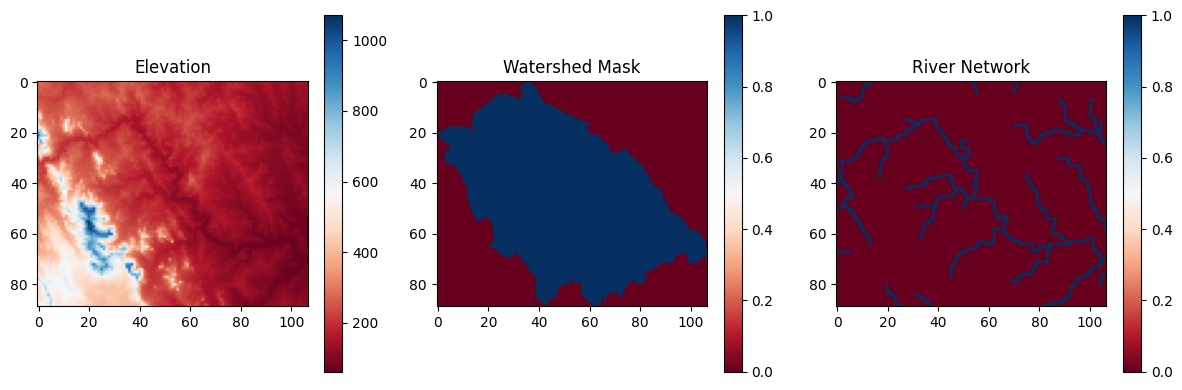

In [ ]:
# Plot inputs (optional - requires matplotlib)
def _plot_inputs():
    """Plot the three input datasets."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    im0 = axes[0].imshow(DEM, cmap='RdBu' )
    axes[0].set_title("Elevation")
    plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(watershed_mask, cmap='RdBu' )
    axes[1].set_title("Watershed Mask")
    plt.colorbar(im1, ax=axes[1])
    im2 = axes[2].imshow(river_mask, cmap='RdBu' )
    axes[2].set_title("River Network")
    plt.colorbar(im2, ax=axes[2])
    plt.tight_layout()
    plt.savefig("workflow_inputs.png", dpi=150)
    plt.show()
    plt.close()
_plot_inputs()

In [ ]:
# Setup target points
init = init_queue(DEM)

No init mask provided all border cells will be added to queue
No domain mask provided using entire domain
No border provided, setting border using domain mask


In [ ]:
# Process the DEM
trav_hs = d4_traverse_b(
    DEM,
    init["queue"].copy(),
    init["marked"].copy(),
    basins=init["basins"].copy(),
    epsilon=0,
    n_chunk=10,
)

In [ ]:
dem_diff = trav_hs["dem"] - DEM
dem_diff[dem_diff==0] = np.nan
targets = init['marked']
targets[targets==0] = np.nan

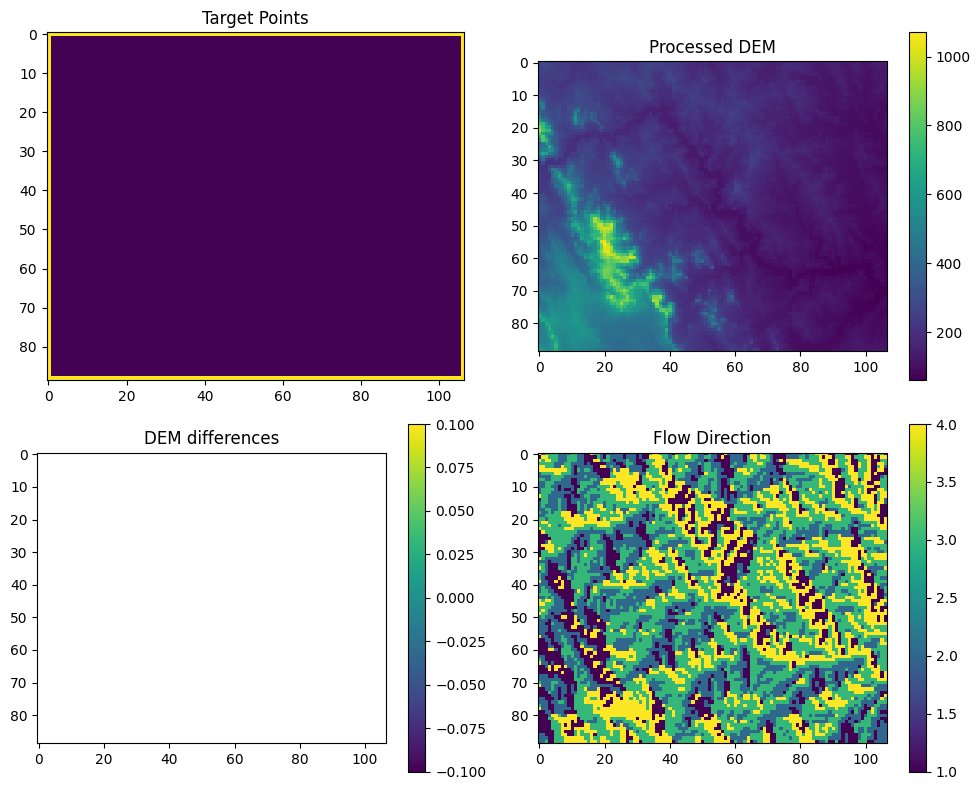

In [ ]:
# Plotting Step 1 results (optional)
def _plot_step1():
    """Plot DEM processing results."""
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes[0, 0].imshow(np.where(np.isnan(targets), 0, 1))
    axes[0, 0].set_title("Target Points")
    im1 = axes[0, 1].imshow(trav_hs["dem"])
    axes[0, 1].set_title("Processed DEM")
    plt.colorbar(im1, ax=axes[0, 1])
    im2 = axes[1, 0].imshow(dem_diff)
    axes[1, 0].set_title("DEM differences")
    plt.colorbar(im2, ax=axes[1, 0])
    im3 = axes[1, 1].imshow(trav_hs["direction"])
    axes[1, 1].set_title("Flow Direction")
    plt.colorbar(im3, ax=axes[1, 1])
    plt.tight_layout()
    plt.savefig("workflow_step1.png", dpi=150)
    plt.show()
    plt.close()
_plot_step1()

## Option 2

In [ ]:
init = init_queue(DEM, domainmask=watershed_mask)

No init mask provided all border cells will be added to queue
No border provided, setting border using domain mask


In [ ]:
for key in init.keys():
    if key == 'direction':
        continue
    R_file = f'/home/ga6/PriorityFlow/init_{key}.txt'
    R_data = np.loadtxt(R_file)
    python_data = init[key]
    print(key, np.array_equal(python_data, R_data))

mask False
queue False
marked False
basins False


In [ ]:
R_file = f'/home/ga6/PriorityFlow/init_queue.txt'
r_queue = np.loadtxt(R_file)
for row in r_queue:
    row[0] -= 1
    row[1] -= 1
np.array_equal(r_queue, init['queue'])

False

In [ ]:
trav_hs = d4_traverse_b(
    DEM,
    init["queue"].copy(),
    init["marked"].copy(),
    mask=watershed_mask,
    basins=init["basins"].copy(),
    epsilon=0,
    n_chunk=10,
)

In [ ]:
trav_hs.keys()

dict_keys(['dem', 'mask', 'marked', 'step', 'direction', 'basins'])

In [ ]:
for key in trav_hs.keys():
    if key == 'direction':
        continue
    R_file = f'/home/ga6/PriorityFlow/travHS_{key}.txt'
    R_data = np.loadtxt(R_file)
    python_data = trav_hs[key]
    print(key, np.array_equal(python_data, R_data))

dem False
mask False
marked False
step False
basins False


## Option 3

In [ ]:
init = init_queue(DEM, domainmask=watershed_mask, initmask=river_mask)

No border provided, setting border using domain mask


In [ ]:
trav_hs = d4_traverse_b(
    DEM,
    init["queue"].copy(),
    init["marked"].copy(),
    mask=watershed_mask,
    basins=init["basins"].copy(),
    epsilon=0,
    n_chunk=10,
)

inital queue: 2 Not splitting


## Step 2.1.

In [ ]:
area = drainage_area(
    trav_hs["direction"].copy(),
    mask=watershed_mask,
    printflag=False,
)

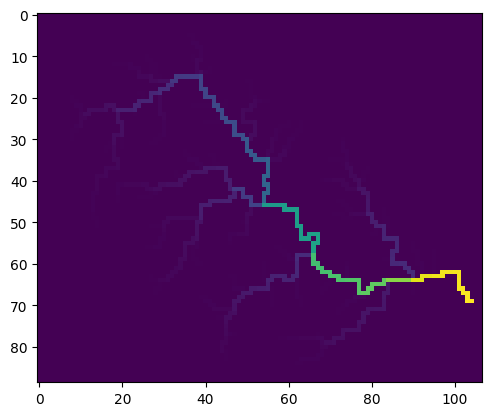

In [ ]:
plt.imshow(area)

## Step 2.2

In [ ]:
subbasin = calc_subbasins(
    trav_hs["direction"].copy(),
    area=area.copy(),
    mask=watershed_mask.copy(),
    riv_th=60,
    merge_th=0,
)

In [ ]:
subbasin.keys()

dict_keys(['segments', 'subbasins', 'RiverMask', 'summary'])

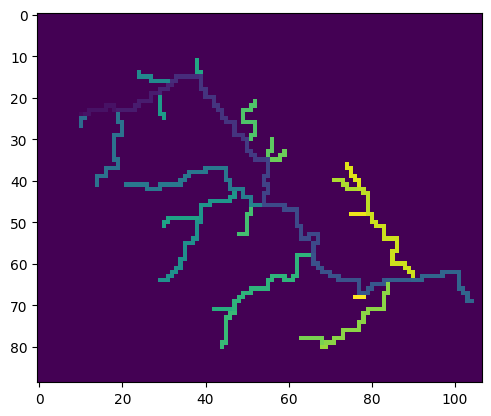

In [ ]:
plt.imshow(subbasin['segments'])

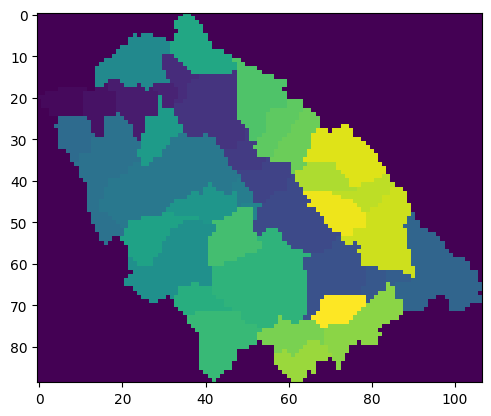

In [ ]:
plt.imshow(subbasin['subbasins'])

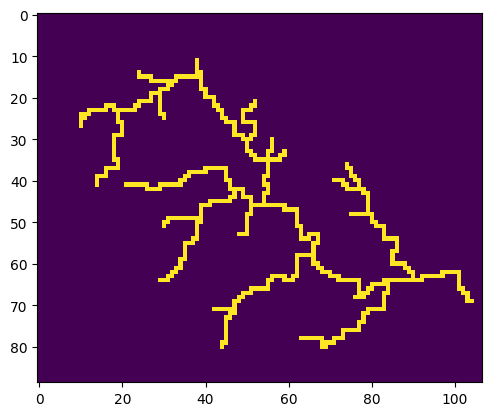

In [ ]:
plt.imshow(subbasin['RiverMask'])

In [ ]:
stream_order = calc_stream_order(
    subbasin["summary"][:, 0],
    subbasin["summary"][:, 5],
    subbasin["segments"].copy(),
)

In [ ]:
stream_order.keys()

dict_keys(['summary', 'order_mask'])

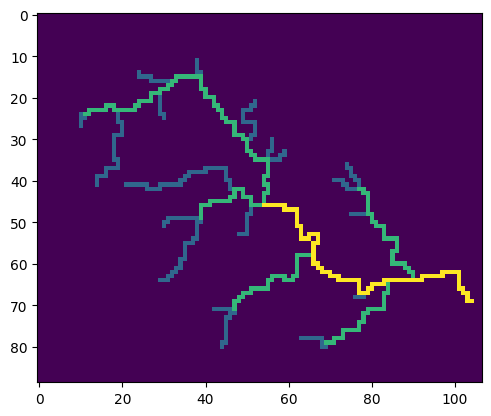

In [ ]:
plt.imshow(stream_order['order_mask'])

In [ ]:
riv_smooth_result = river_smooth(
    dem=trav_hs["dem"].copy(),
    direction=trav_hs["direction"].copy(),
    mask=watershed_mask.copy(),
    river_summary=subbasin["summary"].copy(),
    river_segments=subbasin["segments"].copy(),
    bank_epsilon=1,
)

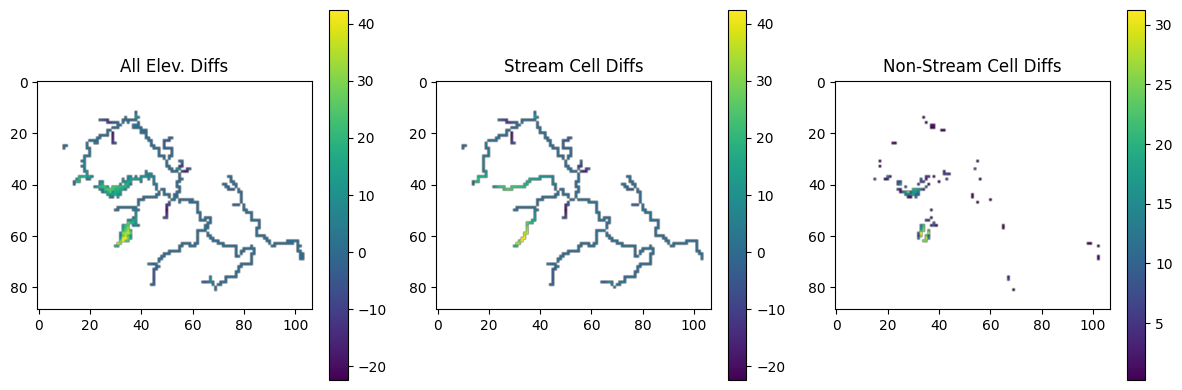

In [ ]:
def _plot_step2():
    """Plot river smoothing results."""
    dif = riv_smooth_result["dem.adj"] - trav_hs["dem"]
    riv_mask = np.where(subbasin["segments"] > 0, 1, 0)
    hill_mask = 1 - riv_mask
    dif_hill = dif * hill_mask
    dif_riv = dif * riv_mask

    dif_plot = np.where(dif == 0, np.nan, dif)
    dif_riv_plot = np.where(dif_riv == 0, np.nan, dif_riv)
    dif_hill_plot = np.where(dif_hill == 0, np.nan, dif_hill)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    im0 = axes[0].imshow(dif_plot)
    axes[0].set_title("All Elev. Diffs")
    plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(dif_riv_plot)
    axes[1].set_title("Stream Cell Diffs")
    plt.colorbar(im1, ax=axes[1])
    if np.any(~np.isnan(dif_hill_plot)):
        im2 = axes[2].imshow(dif_hill_plot)
        axes[2].set_title("Non-Stream Cell Diffs")
        plt.colorbar(im2, ax=axes[2])
    plt.tight_layout()
    plt.savefig("workflow_step2_smoothing.png", dpi=150)
    plt.show()
    plt.close()

_plot_step2()

In [ ]:
slopes_calc = slope_calc_standard(
    dem=riv_smooth_result["dem.adj"].copy(),
    direction=trav_hs["direction"].copy(),
    mask=watershed_mask.copy(),
    minslope=1e-5,
    maxslope=1,
    dx=1000,
    dy=1000,
    secondary_th=-1,
)

In [ ]:
slopes_calc.keys()

dict_keys(['slopex', 'slopey', 'direction', 'Sinks'])

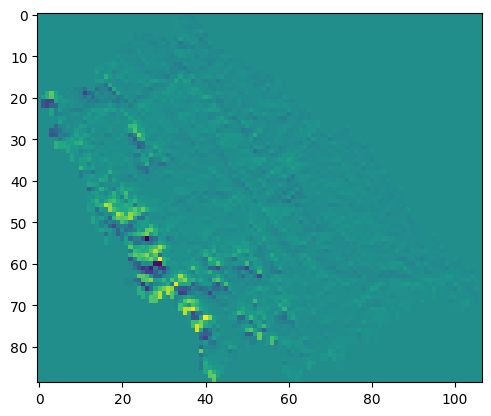

In [ ]:
plt.imshow(slopes_calc['slopex'])

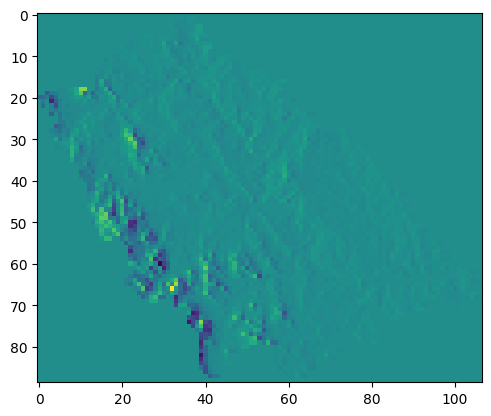

In [ ]:
plt.imshow(slopes_calc['slopey'])

In [ ]:
river_mask_slope = np.where(subbasin["segments"] > 0, 1, 0)
slopes_calc2 = riv_slope(
    direction=trav_hs["direction"].copy(),
    slopex=slopes_calc["slopex"].copy(),
    slopey=slopes_calc["slopey"].copy(),
    minslope=1e-4,
    river_mask=watershed_mask.copy(),
    remove_sec=True,
)

In [ ]:
slopes_calc2.keys()

dict_keys(['slopex', 'slopey', 'adj_mask', 'SlopeOutlet', 'SlopeOutletNew'])

In [ ]:
slopex = slopes_calc2["slopex"]
slopey = slopes_calc2["slopey"]

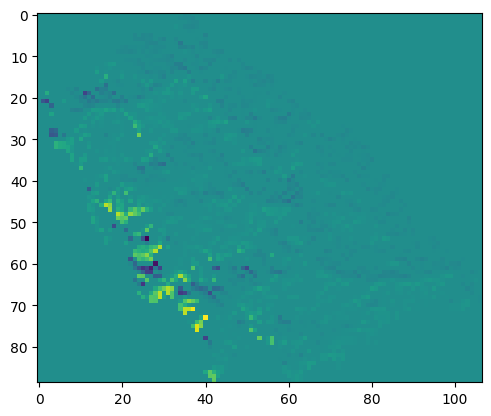

In [ ]:
plt.imshow(slopex)

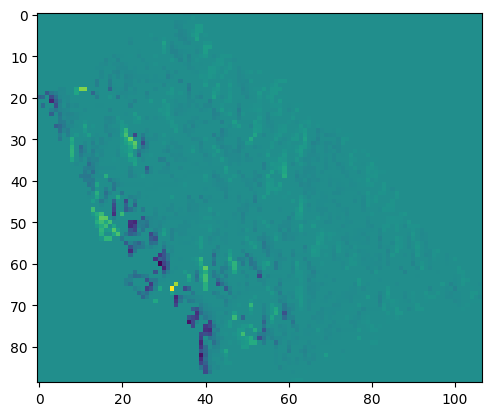

In [ ]:
plt.imshow(slopey)